In [1113]:
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon
from matplotlib import pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pylab as pylab
import cv2

In [1114]:
def apply_canny(image):
    # img = cv2.medianBlur(image, 9)                 # 模糊化，去除雜訊
    output = cv2.Canny(image, 10, 35) 
    return output

In [1115]:
def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [1116]:
def shortlist_lines(lines):
    MIN_ANGLE = 15
    MAX_ANGLE = 90
    MIN_DIST  = 750
    MAX_DIST  = 1000
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

In [1117]:
def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    # print(shortlisted_lines)
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [1118]:
def threshold_mask(img):
    thres_img = np.zeros_like(img)
    # Define a threshold value
    threshold_value = 160

    # Iterate over each pixel in the image
    for i in range(thres_img.shape[0]):
        for j in range(thres_img.shape[1]):
            # Apply threshold to each pixel individually
            if thres_img[i, j] > threshold_value:
                thres_img[i, j] = 255
            else:
                thres_img[i, j] = 0

    return thres_img

In [1119]:
def display_image(image, cla_image):
    rows, cols = image.shape
    # print(image)
    # blurred = cv2.GaussianBlur(image, (15, 15), 0)
    # img_binary = threshold_mask(image)
    img = cv2.medianBlur(image, 33)  
    canny_image = apply_canny(img)
    # canny_image = cv2.Sobel(image, -1, 1, 1, 1, 3)
    filtered_image = cv2.filter2D(canny_image, -1, np.array([[0, 2, 0], [2, 2, 2], [0, 2, 0]]))
    lines = get_hough_lines(filtered_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Blurred')
    axes[0].imshow(img, cmap=pylab.cm.gray)
    axes[0].axis('on') 

    axes[1].set_title('Canny')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on') 
    
    axes[2].set_title('Hough Lines on Canny Edge Image')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[3].set_title('Shortlisted Lines')
    axes[3].imshow(canny_image, cmap=pylab.cm.gray)
    axes[3].axis('on')
    axes[3].set_xlim(0,image.shape[1])
    axes[3].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[3].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    rr, cc = remove_pectoral(shortlisted_lines)

    # Create a boolean mask for the conditions
    mask = (rr < rows) & (cc < cols)

    # Set values to 0 where the conditions are met
    cla_image[rr[mask], cc[mask]] = 0
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(cla_image, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    plt.show() 

    new_path = "../../datasets/image/clean_png/out.png"
    cv2.imwrite(new_path, cla_image)


All hough lines
Angle: 90.00, Dist: 17.50
Angle: -0.50, Dist: 1038.66
Angle: 0.50, Dist: 971.65
Angle: 17.60, Dist: 964.65
Angle: 6.54, Dist: 464.57
Angle: -13.58, Dist: 308.55
Angle: 4.53, Dist: 1013.66
Angle: 0.50, Dist: 995.65
Angle: -7.54, Dist: 536.58
Angle: -12.57, Dist: 297.55
Angle: -3.52, Dist: 737.61
Angle: -4.53, Dist: 721.61
Angle: -13.58, Dist: 326.55
Angle: -1.51, Dist: 940.64
Angle: 4.53, Dist: 433.57
Angle: -4.53, Dist: 693.61
Angle: -13.58, Dist: 244.54
Angle: 18.60, Dist: 997.65
Angle: -10.56, Dist: 510.58
Angle: 1.51, Dist: 1130.67
Angle: 9.55, Dist: 661.60
Angle: -0.50, Dist: 409.56
Angle: -2.51, Dist: 750.61
Angle: -9.55, Dist: 560.59
Angle: -15.59, Dist: 25.50
Angle: -16.59, Dist: -26.50
Angle: 18.60, Dist: 1012.65
Angle: -7.54, Dist: 655.60
Angle: 3.52, Dist: 1073.66
Angle: 0.50, Dist: 868.63
Angle: -1.51, Dist: 787.62
Angle: -21.62, Dist: -139.52
Angle: 13.58, Dist: 786.62
Angle: -7.54, Dist: 669.60
Angle: -1.51, Dist: 376.56
Angle: -15.59, Dist: 150.52
Angle: 

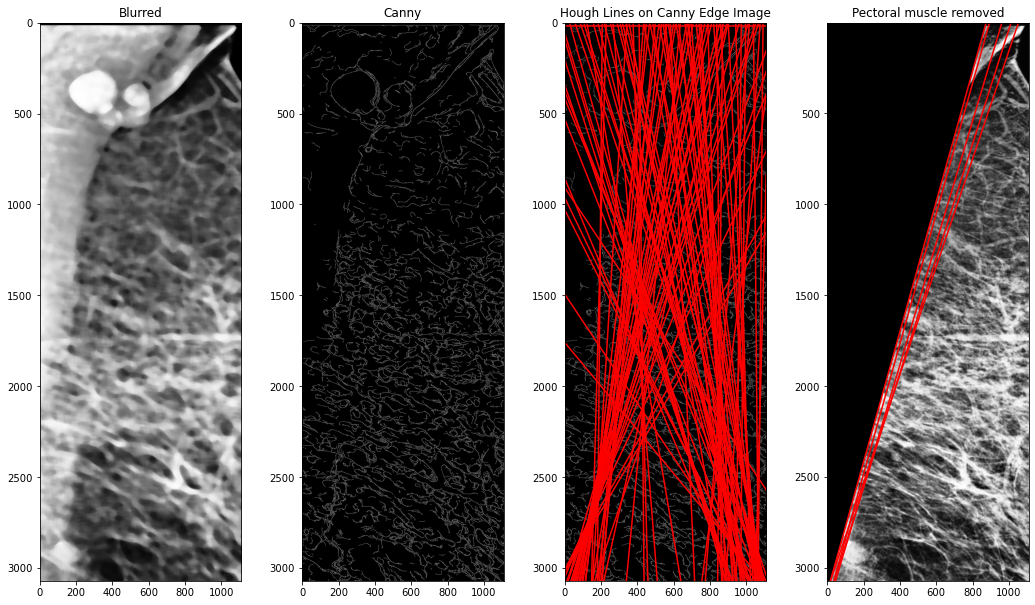

In [1120]:
test_pic = "../../datasets/image/clean_png/test5_clahe.png"
clahe_pic = "../../datasets/image/clean_png/test5_clahe.png"
cla_image = cv2.imread(clahe_pic, 0)
image = cv2.imread(test_pic, 0)
rows, cols = image.shape
roi = image[:3 * rows//4, :cols//3]
# print(roi)
display_image(roi, cla_image)